# Project 3 Part 3: Model and Insights

This workbook is 3 out of 3 parts of an Natural Language Processing (NLP) classification model. The focus of this part is to select best model based on accuracy score and least false negatives, tune for accuracy, and perform error analysis.

## Model selection criteria and expectation on error analysis

I have chosen to evaluate the models based on the following:
    
1) Overall accuracy based on test score - from this I have chosen Logistic Regression models over Multinomial Naive Bayes models as they were more simply more accurate.

2) Highest sensivity - the Vectorizer used will be evaluated within the Logistic Regression models section.

3) Time to fit and optimise model - with this criteria I have disqualified both Random Forest models, as it takes a significant amount of time to fit and optimize the models. It is likely that chatbots will need to have a close to instantaneous reply, and time is not a luxury for such classifier to be useful.

I have kept my workflow in tact in this workbook, and not rearranged the sequential modeling process I have done, which started from Multinomial Naive Bayes, to Logistic Regression and lastly to Random Forest models. However, error analysis is done only on the finalized model, which is Logistic Regression.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
# Create dataframes by reading csv
df = pd.read_csv('../datasets/cleaned.csv')

In [3]:
pd.options.display.max_colwidth = 4000

## Stopwords

In [4]:
custom_stopwords = stopwords.words('english')

In [5]:
# Add additional stop words based on subreddit names
new_words = ['no',
             'stupid',
             'legal',
             'advice',
             'advices',
             'question',
             'questions']

In [6]:
# Include new words into stopwords list
custom_stopwords.extend(new_words)

In [7]:
# Analyse proportions of 1 - belongs to r/legaladvice and 0 - belongs to r/NoStupidQuestions
df['subreddit'].value_counts()

1    11973
0    11760
Name: subreddit, dtype: int64

In this dataset which I have full control of when datascraping, the distribution of 1 and 0 are relatively balanced. This may not be realistic in real life, and it is very likely that there would be much lesser legal queries compared to normal questions in real life.

#### Baseline score

In [8]:
# Baseline score
df['subreddit'].value_counts(normalize=True)

1    0.504487
0    0.495513
Name: subreddit, dtype: float64

For model evaluation purpose, I expect my model to minimally perform better than 50.4%.

## Set X and y variables/ Train test split

In [9]:
# Use lemmatized combined text for X and y
X = df['lem_combi_text']
y = df['subreddit']

In [10]:
# Train test split for lemmatized text
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y, 
    random_state=42
)

In the optimisation of my models, non lemmatized text will be compared against lemmatized text to determine which improves model accuracy.

In [11]:
# Use non lemmatized text for X and y
X1 = df['combi_text']
y1 = df['subreddit']

In [12]:
# Train test split for non lemmatized text

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1,
    y1,
    test_size=0.25,
    stratify=y, 
    random_state=42
)

For the purpose of train test split, stratify will be in place to make sure to keep the proportions in tact. Proportions of the two subreddits is quite balanced.

## Modelling

For the purpose of model evaluation, the models will use their default hyperparameters first.

I have then used GridSearch to select the hyperparameters that give the highest accuracy. To keep the documentation succinct, the hyperparameters I will be putting the optimized hyperparameters below the GridSearch cell, so that reviewers can save the running time that GridSearch may take.

### Instantiate all models for use later

In [13]:
#Instantiate models
cvec = CountVectorizer(stop_words=custom_stopwords)
tvec = TfidfVectorizer(stop_words=custom_stopwords)
nb = MultinomialNB()
lr = LogisticRegression(solver='liblinear')

# Instantiate RandomForest Classifier, n_jobs=-1 to use all cores
rf = RandomForestClassifier(n_jobs=-1)

## Multinomial Naive Bayes, and justification to use non lemmatized text

As the results are going to be counts of subreddit, which would be integer counts, the most appropriate would be Multinomial Naive Bayes model, which I would be performing as my first baseline model.

### Base model - 1) CVEC Multinomial NB on lemmatized combined text 

In [14]:
# Create pipeline for CVEC Multinomial NB
cvecnb = Pipeline([
    ('cvec', cvec),
    ('nb', nb)
])

In the next steps, I wish to check if lemmatized combined text would make my model perform better than unlemmatized text. Thus, there are two iterations of models, 1) and 1b) which investigates which type of text is optimal.

In [15]:
cvecnb.fit(X_train, y_train);

In [16]:
cvecnb.score(X_train, y_train)

0.9314568234170459

In [17]:
cvecnb.score(X_test, y_test)

0.9063026626221773

### Improved base model - 1b) CVEC Multinomial NB on non-lemmatized combined text

In [18]:
cvecnb.fit(X1_train, y1_train);

In [19]:
cvecnb.score(X1_train, y1_train)

0.9352772627675712

In [20]:
cvecnb.score(X1_test, y1_test)

0.9108527131782945

#### Comparison of 1 and 1b - Non-lemmatized combined text increased accuracy by 0.4%

It was interesting to see that just by changing the feature to non lemmatized text, the accuracy increased by 0.4% for both train and test data. This showed me that contrary to what I expected, lemmatizing may not always be helpful in improving accuracy in the model. As lemmatizing has decreased model accuracy, stemming which is even more aggressive will not be looked into. Furthermore, lemmatizing is not a must do, so since I am given the luxury to choose, I would choose to not lemmatize from here on out.

From my understanding, non lemmatized text might have worked better in accuracy as Redditors tend to use colloquial short forms and mispellings that are not available on WordNet. By lemmatizing the text, lots of meaning and key words would be lost.

#### Conclusion with using only non-lemmatized combined text from here on out

I have further tested in other models that indeed non lemmatized combined text performed better in accuracy than lemmatized text. With the purpose of keeping the notebook succinct, I will not futher include comparisons of lemmatized versus non lemmatized combined text scores.

### Final optimised model 1) CVEC Multinomial NB on non-lemmatized combined text

In [21]:
# Final optimised hyperparameters inside as shown
# Hyperparameters tuning with GridSearchCV
cvecnb_params = {'cvec__ngram_range': [(1,1), (1,2), (1,3)],
               'nb__alpha': [0.1, 0.37, 0.5]}

cvecnb_gs = GridSearchCV(cvecnb, param_grid=cvecnb_params, n_jobs=-1, verbose=2, cv=3)
cvecnb_gs.fit(X1_train, y1_train);
print("Best score:", cvecnb_gs.best_score_)
print("Train score", cvecnb_gs.score(X1_train, y1_train))
print("Test score", cvecnb_gs.score(X1_test, y1_test))

cvecnb_gs.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best score: 0.9105567728524074
Train score 0.9417944828361144
Test score 0.9140546006066734


{'cvec__ngram_range': (1, 1), 'nb__alpha': 0.37}

In [22]:
# For reference:
#{'cvec__ngram_range': (1, 1), 'nb__alpha': 0.37}
#Best score: 0.9105567728524074
#Train score 0.9417944828361144
#Test score 0.9140546006066734

### Usage of a different vectorizer - TF-IDF Vectorizer

Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer overcomes a limitation of CountVectorizer, which simply give a count, by focusing on important words that appear on often in one document but don't appear in many documents. It is expected to have more predictive power especially when terminologies and jargons are commonly used in law.

From my EDA, I noted that for both r/NoStupidQuestions and `r/legaladvice`, the top 10 common words are the same for TF-IDF and CountVectorizer. Only the order changed, showing that there is no dispute what the most common words are.

I would expect that TF-IDF Vectorizer should perform better as the top common words in `r/NoStupidQuestions` are very commonly used conversational english words. From here on out I refer to TF-IDF Vectorizer and TVEC interchangeably.

### Model - 2) TF-IDF Vectorizer (TVEC) Multinomial NB on non-lemmatized combined text

In [23]:
# Create pipeline for TVEC Multinomial NB
tvecnb = Pipeline([
    ('tvec', tvec),
    ('nb', nb)
])

In [24]:
tvecnb.fit(X1_train, y1_train);

In [25]:
tvecnb.score(X1_train, y1_train)

0.9143210292713074

In [26]:
tvecnb.score(X1_test, y1_test)

0.8828783282777216

Model 2 before optimised hyperparameters tweaking performed worst than model 1 base model. However, I will be tweaking hyperparameters later on, before I make any conclusion. As there is a possibility that after hyperparameter tuning, model 2 can outperform model 1, it is important to not make any preliminary conclusions from the accuracy that comes using default hyper parameters.

In [28]:
# Final optimised hyperparameters inside as shown
# Hyperparameters tuning with GridSearchCV
tvecnb_params = {'tvec__max_df': [0.1, 0.5],
               'tvec__min_df': [2, 3, 4],
               'tvec__ngram_range': [(1,1),(1,2),(1,3)],
               'nb__alpha': [0.1, 0.2, 0.3]}

tvecnb_gs = GridSearchCV(tvecnb, param_grid=tvecnb_params, n_jobs=-1, verbose=2, cv=3)
tvecnb_gs.fit(X1_train, y1_train);
print("Best score:", tvecnb_gs.best_score_)
print("Train score", tvecnb_gs.score(X1_train, y1_train))
print("Test score", tvecnb_gs.score(X1_test, y1_test))

tvecnb_gs.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best score: 0.9162874318781954
Train score 0.9687061070846676
Test score 0.9180990899898888


{'nb__alpha': 0.1,
 'tvec__max_df': 0.5,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 3)}

In [28]:
# For reference:
# {'nb__alpha': 0.1,
#'tvec__max_df': 0.5,
#'tvec__min_df': 3,
#'tvec__ngram_range': (1, 3)}
    
#Best score: 0.9162874318781954
#Train score 0.9687061070846676
#Test score 0.9180990899898888

### Learning point and observation from hyperparameters tuning

I learnt from the step above that a model may seem to underperform compared to another model initially, however, with hyperparameters tuning, it has a chance to end up outperforming the other model. From this, I have learnt not to make any premature conclusion, but to look at model selection and evaluation together with tuning.

As expected, TF-IDF Vectorizer did improved accuracy for Multinomial NB. It is likely due to the limitation of CountVectorizer, which simply give a count, while TF-IDF focusing on important words that appear on often in one document but don't appear in many documents, it has indeed given more predictive power especially when terminologies and jargons are commonly used in law.

On a side note, GridSearch showed that with a different model and vectorizer, the optimised ngram range differs (at time it may be unigrams and trigrams, at others it may be unigrams and bigrams. This underscores the importance to do hyperparameter tuning for each model, even though the underlying dataset is the same, and the mechanics of each learning model will run differently, giving rise to different optimizations.

## Feature importance based on TVEC Multinomial NB

In [29]:
tvecnb_gs.best_estimator_['nb'].feature_log_prob_;

In [30]:
gs_tvec = tvecnb_gs.best_estimator_['tvec'].get_feature_names_out()

In [31]:
log_prob_difference = tvecnb_gs.best_estimator_['nb'].feature_log_prob_[1] - tvecnb_gs.best_estimator_['nb'].feature_log_prob_[0]

In [32]:
len(gs_tvec)

81717

In [33]:
log_prob_difference.shape

(81717,)

In [34]:
df_features = pd.DataFrame(data=log_prob_difference, index=gs_tvec)
df_features.columns = ['log_prob_difference']

In [35]:
df_features.sort_values(by='log_prob_difference', ascending=False).head(10)

,log_prob_difference
llc,4.804310
small claims,4.631508
court date,4.574062
termination,4.534524
eviction,4.530112
felony,4.411986
misdemeanor,4.375482
tenant,4.367443
hoa,4.289719
claims court,4.228177


For the largest positive log_prob_difference values suggests that these are important words that justifies a post belongs to `r/legaladvice` than `r/NoStupidQuestions`. It is very understandable as quite alot of legal jargons are used here.

In [36]:
df_features.sort_values(by='log_prob_difference', ascending=True).head(10)

,log_prob_difference
humans,-5.158139
calories,-4.467350
daylight savings,-4.442010
cringe,-4.360837
tastes,-4.254929
gas prices,-4.250506
heaven,-4.184990
bible,-4.140652
cultures,-4.125408
iq,-4.118611


On the other hand, the negative log_prob_difference values suggests that these are important words that justifies a post belongs to `r/NoStupidQuestions` than `r/legaladvice`.

In [37]:
# Filter out features that are close to 0, as they are expected to makes no difference
df_features[(df_features['log_prob_difference']<0.05) & (df_features['log_prob_difference']>-0.05)]

,log_prob_difference
abandon,0.046401
abandoning,0.047934
abc,-0.014942
able hold,-0.004906
able talk,-0.035111
...,...
yet asked,0.031911
yet still,-0.002591
youre taking,0.035320
youre telling,0.006382


For the dataframe above, it contains words that are expected to be widely used in both subreddits. I have tried using the list as extended stopwords, but they did not help to improve the accuracy rates for my finalised model using TVEC and logistic regression.

### Model - 3) CVEC logistic regression on non lemmatized combined text

In [38]:
# Create pipeline for CVEC Logreg
cveclr = Pipeline([
    ('cvec', cvec),
    ('lr', lr)
])

In [39]:
cveclr.fit(X1_train, y1_train);

In [40]:
cveclr.score(X1_train, y1_train)

0.9952806337434688

In [41]:
cveclr.score(X1_test, y1_test)

0.9290529154027637

In [42]:
# Optimised 
# Tune GridSearchCV
cveclr_params = {'cvec__max_features':[None, 10000,200000],
               'cvec__ngram_range': [(1,1),(1,2),(1,3)],
               'lr__C': [0.5, 1],
                }

cveclr_gs = GridSearchCV(cveclr, param_grid=cveclr_params, n_jobs=-1, verbose=2, cv=3)
cveclr_gs.fit(X1_train, y1_train);
print("Best score:", cveclr_gs.best_score_)
print("Train score", cveclr_gs.score(X1_train, y1_train))
print("Test score", cveclr_gs.score(X1_test, y1_test))

cveclr_gs.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best score: 0.930108433058037
Train score 0.9988763413674926
Test score 0.9309066397034041


{'cvec__max_features': 200000, 'cvec__ngram_range': (1, 2), 'lr__C': 1}

In [43]:
# for reference:
#{'cvec__max_features': 200000, 'cvec__ngram_range': (1, 2), 'lr__C': 1}
#Best score: 0.930108433058037
#Train score 0.9988763413674926
#Test score 0.9309066397034041

CountVectorizer with logistic regression performed the best by score on train data. There is a worrying sign of overfitting as train data score is significantly higher than test score.

In [44]:
pred = cveclr_gs.predict(X1_test)

In [45]:
confusion_matrix(y1_test, pred);

In [46]:
cm = confusion_matrix(y1_test, pred)

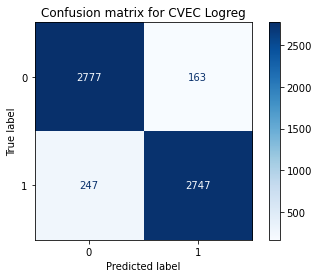

In [47]:
# Plot confusion matrix 

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion matrix for CVEC Logreg')
plt.show()

In [48]:
tn, fp, fn, tp = confusion_matrix(y1_test, pred).ravel()

In [49]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2777
False Positives: 163
False Negatives: 247
True Positives: 2747


In [50]:
sensitivity = tp/(tp+fn)
sensitivity

0.91750167000668

### Model - 4) TVEC logistic regression on non lemmatized combined text (My chosen model)

In [51]:
# Create pipeline for TVEC Logreg
tveclr = Pipeline([
    ('tvec', tvec),
    ('lr', lr)
])

In [52]:
tveclr.fit(X1_train, y1_train);

In [53]:
tveclr.score(X1_train, y1_train)

0.9551098376313276

In [54]:
tveclr.score(X1_test, y1_test) 

0.9344455679137176

In [66]:
# Hyperparameters tuning - > not optimised for test score though, but selected as final model
# Tune GridSearchCV
tveclr_params = {'tvec__max_df': [0.5, 0.75],
               'tvec__min_df': [4,5],
               'tvec__ngram_range': [(1,1),(1,2),(1,3)],
               'lr__C': [0.5, 1]}

tveclr_gs = GridSearchCV(tveclr, param_grid=tveclr_params, n_jobs=-1, verbose=2, cv=3)
tveclr_gs.fit(X1_train, y1_train);
print("Best score:", tveclr_gs.best_score_)
print("Train score", tveclr_gs.score(X1_train, y1_train))
print("Test score", tveclr_gs.score(X1_test, y1_test))

tveclr_gs.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best score: 0.9299398842631609
Train score 0.9598292038878589
Test score 0.9344455679137176


{'lr__C': 1,
 'tvec__max_df': 0.5,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

In [63]:
#{'lr__C': 1,
 #'tvec__max_df': 0.5,
 #'tvec__min_df': 5,
 #'tvec__ngram_range': (1, 2)}

#Best score: 0.9299398842631609
#Train score 0.9598292038878589
#Test score 0.9344455679137176

TF-IDF Vectorizer with logistic regression performed the best by score on test data. There is less overfitting compared to model 3 as well. This is likely due to how the TF-IDF Vectorizer penalises words that commonly appear across all threads, so that key words gain more importance, unlike CountVectorizer which simply counts every occurence.

Logistic regression models is the model that gives me the best accuracy score based on test data. As such, I will be choosing between TVEC and CVEC logistic regression models as my final model. Unfortunately, there is no feature importance function with logistic regression that I can utilise, as such, I will be using other feature importance functions, with Multinomial NB and Random Forest to help identify where I can further improve the accuracy rates.

Accuracy is also not the only important factor. As such, I will be looking beyond accuracy, and look at the confusion matrix, as well as to identify trends in misclassified data, to see if any corrective action can be taken preemptively.

In [67]:
pred = tveclr_gs.predict(X1_test)

In [68]:
confusion_matrix(y1_test, pred);

In [69]:
cm = confusion_matrix(y1_test, pred)

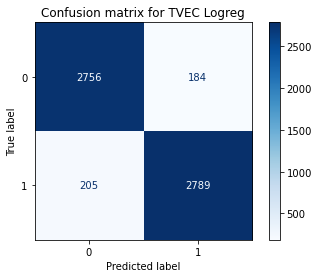

In [70]:
# Plot confusion matrix 

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion matrix for TVEC Logreg')
plt.show()

In [71]:
tn, fp, fn, tp = confusion_matrix(y1_test, pred).ravel()

In [72]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2756
False Positives: 184
False Negatives: 205
True Positives: 2789


In [73]:
sensitivity = tp/(tp+fn)
sensitivity

0.9315297261189045

Accuracy is also not the most important factor. As such, I will be looking beyond accuracy, and look at the confusion matrix, as well as to identify trends in misclassified data, to see if any corrective action can be taken preemptively. 

My problem statement seeks to help organizations mitigate legal risk and unintended liabilities. As such, there is an importance to look at the positives, and therefore sensitivity is the most important metric to evaluate the model.

Minimizing false negatives, which means minimizing legal advices that were misclassified as non legal queries, would be more important since I wish to minimize the risk exposure of organisations who receive legal queries through their chatbots. As such, when comparing TVEC Logistic Regression model with CVEC Logistic Regression model, TVEC Logistic Regression model outperforms CVEC Logistic Regression model to keep the false negatives lower, and have a higher sensivity score overall (93.2% versus 91.8%).

## Error analysis of final chosen model

In [74]:
# Create dataframe with y1_test values
df_actual_pred = pd.DataFrame(y1_test)

# Create predicted column based on predictions from chosen model
df_actual_pred['predicted'] = pred
df_actual_pred.rename(columns={'subreddit': 'actual'}, inplace=True)
df_actual_pred.head()

,actual,predicted
22249,1,1
392,0,0
4300,0,0
8595,0,0
22225,1,1


In [75]:
# Concatenate dataframe of X1 test and prediction
df_classify = pd.concat([X1_test, df_actual_pred], axis=1)
df_classify.head()

,combi_text,actual,predicted
22249,apartment complex forces residents to send packages to a thirdparty and pay a monthly fee for redelivery my apartment complex has all its residents agree to have their packages sent to a thirdparty that then redelivers the packages to the residents for a monthly fee the company in question is called fetch we pay the complex for the service not fetch im wondering if this holds up legally can an apartment complex really have residents waive their right to receive packages sent to their legal address this seems unethical and reeks of exploitation while purely speculation it stands to reason that the apartment complex likely worked out a deal with fetch fifteen dollars per month may not be much but fifteen dollars per month per resident is an exorbitant amount of money the complex argues that its for the safety of our packages but the way i see it a fifteen dollar package is being stolen from me every month now moreover the package they redeliver can still be stolen the fact that they likely generate income through this arrangement is also a red flag so is this in fact legal what are my options aside from moving somewhere else,1,1
392,what is your favorite tea just ran out of lipton tea and looking to try new ones what do you recommend,0,0
4300,in terms of war are average citizens in a country just seen as war expenses to the government in the past politicians just send the poor people to go fight their wars for them tools and an expense for a political agenda is it still the same today,0,0
8595,why do rappers like hennessy so much it tastes like ass,0,0
22225,wondering about some charges i recently got arrested on so as the title says im trying to get some thoughts on charges i recently got arrested on so i male live in california which is where this all takes place i entered a chain hardware store on a wednesday afternoon with the intention of stealing a chainsaw i walked around the store a little bit then walked up to where the saws are they arent locked up but they have a phone cord that if you unclip sets off an alarm so i unclip the cord grab the saw and run for the door just before i get out the door a female employee latches onto my collar while im at full sprint we both collapse into the door she is death gripped on my shirt so i begin to slip out of my shirt at which point another employee grams me from behind and places my arms in a way a cop would before they cuff you i tried to pull away and he begins bending my arm until its about to snap so i stop resisting the one who initially grabbed me is screaming to call the cops so cops show up cuff me and take me in the back of store to review the footage they say after the lady grabbed me i attempted to hit her i know this is untrue and they charge me with a robbery with attempted great bodily injury and petty theft i did days in jail before bailing out court next month what should i expect will these charges stick the store has a no chase no touch policy for theft i have a public defender this happened in california should i prepare for the robbery charge sticking thank you for any and all advice,1,1


In [76]:
# Create word count column
df_classify['word_count'] = df_classify['combi_text'].apply(lambda x: len(str(x).split(' ')))

In [77]:
# Find indices where predicted and true results were not the same
classify_wrong = df_classify[df_classify['predicted'] != df_classify['actual']]
classify_wrong.head()

,combi_text,actual,predicted,word_count
12842,is this bounds to press charges for harassment i dont really know because i like this girl let me know dont really know what sub to post this in ive put it in others and no one responds with the advice im looking for if this is the wrong place feel free to remove i m work at a supermarket with this women f who i find very pretty i havent gotten the courage to talk to her myself because im very quiet and shy and shes super outgoing and charismatic the entire staff loves her i find it very intimidating to be honest anyway she always acts in ways towards me that i dont understand when im having conversations with people and shes not involved with it shell mimic my voice in a high pitched voice while walking by she also taps me on the shoulder and head when im not looking and acts like she didnt i randomly will catch her staring at me and when i look over shell just smile at me and look away the other day there was a staff meeting and on the way out of the room some guy was talking about ropes in reference to some sort of project hes working on and she whispered to me you have no idea how bad i want to use those on you in a super serious voice now whenever she walks by me she just smiles at me it kind of feels like its in a way where she thinks she has an upper hand on me she said to me the other day when she walked by i know youre thinking about what i said and i love doing this to you seeing you uncomfortable is so cute then she tapped my nose and walked away to be honest it kind of freaks me out to be honest though i think shes super hot and i would be interested in a relationship with her but i dont know if shes into me or if shes just trying to fuck with my head she doesnt act like this with anyone else and i havent told any of the other staff because shes adored by everyone and i dont want to sound weird or like an idiot cuz everyone already kind of thinks of me as that shy awkward dude anyway what do you guys think of this at first i thought it was just friendly flirting but ive put this in other subs and many people have told me this is harassment and i need to do something about it,1,0,437
8633,how do i make it up to my girlfriend so basically i messed up with my girlfriend weve been dating for over two years but i went behind her back and did things that i regret deeply i went behind her back and watched porn which i promised not to do and i sexualized other girls i lied to her for almost all of the relationship i recently came clean and told her everything she considers the things ive done as cheating i hurt her so much but she decided to give me another chance i love her so much and am so grateful that shes giving me another chance i really want to make things up with her i am looking for any suggestions to try to help thank you,0,1,131
1925,tax and w form drama so i worked at this small town beauty salon during the summer my friend helped me get the job the whole salon was a mess and people were slowly leaving when i got hired didnt know any of the drama was happening when i got hired or i wouldve applied everywhere else before working there well anyways i did and i had an opportunity i told them i was taking and they said ok no one seemed mad well my friend then while i was away tried to scam me and did some other not friendly things and i was a bit of a bitch back but not a bitch for no reason it was just added up angst and she wanted to be mad about something but was really only mad i was calling her out and im not stupid i know how rent on an apartment works anyways so much drama and here i am months later i never received my w so i messaged the owner she asked for my email and said she would and she still hasnt ive messaged her already again since she asked for email and she opened it but still no email i dont want to be annoying i know she sold the company to her friend but that doesnt mean shes done with all the backed up paper work she neglected to ever come to wor

In [78]:
classify_wrong.shape

(389, 4)

In [79]:
classify_wrong.head()

,combi_text,actual,predicted,word_count
12842,is this bounds to press charges for harassment i dont really know because i like this girl let me know dont really know what sub to post this in ive put it in others and no one responds with the advice im looking for if this is the wrong place feel free to remove i m work at a supermarket with this women f who i find very pretty i havent gotten the courage to talk to her myself because im very quiet and shy and shes super outgoing and charismatic the entire staff loves her i find it very intimidating to be honest anyway she always acts in ways towards me that i dont understand when im having conversations with people and shes not involved with it shell mimic my voice in a high pitched voice while walking by she also taps me on the shoulder and head when im not looking and acts like she didnt i randomly will catch her staring at me and when i look over shell just smile at me and look away the other day there was a staff meeting and on the way out of the room some guy was talking about ropes in reference to some sort of project hes working on and she whispered to me you have no idea how bad i want to use those on you in a super serious voice now whenever she walks by me she just smiles at me it kind of feels like its in a way where she thinks she has an upper hand on me she said to me the other day when she walked by i know youre thinking about what i said and i love doing this to you seeing you uncomfortable is so cute then she tapped my nose and walked away to be honest it kind of freaks me out to be honest though i think shes super hot and i would be interested in a relationship with her but i dont know if shes into me or if shes just trying to fuck with my head she doesnt act like this with anyone else and i havent told any of the other staff because shes adored by everyone and i dont want to sound weird or like an idiot cuz everyone already kind of thinks of me as that shy awkward dude anyway what do you guys think of this at first i thought it was just friendly flirting but ive put this in other subs and many people have told me this is harassment and i need to do something about it,1,0,437
8633,how do i make it up to my girlfriend so basically i messed up with my girlfriend weve been dating for over two years but i went behind her back and did things that i regret deeply i went behind her back and watched porn which i promised not to do and i sexualized other girls i lied to her for almost all of the relationship i recently came clean and told her everything she considers the things ive done as cheating i hurt her so much but she decided to give me another chance i love her so much and am so grateful that shes giving me another chance i really want to make things up with her i am looking for any suggestions to try to help thank you,0,1,131
1925,tax and w form drama so i worked at this small town beauty salon during the summer my friend helped me get the job the whole salon was a mess and people were slowly leaving when i got hired didnt know any of the drama was happening when i got hired or i wouldve applied everywhere else before working there well anyways i did and i had an opportunity i told them i was taking and they said ok no one seemed mad well my friend then while i was away tried to scam me and did some other not friendly things and i was a bit of a bitch back but not a bitch for no reason it was just added up angst and she wanted to be mad about something but was really only mad i was calling her out and im not stupid i know how rent on an apartment works anyways so much drama and here i am months later i never received my w so i messaged the owner she asked for my email and said she would and she still hasnt ive messaged her already again since she asked for email and she opened it but still no email i dont want to be annoying i know she sold the company to her friend but that doesnt mean shes done with all the backed up paper work she neglected to ever come to wor

In [80]:
classify_wrong['word_count'].sort_values(ascending=False).head(10)

21267    618
9007     485
12842    437
1484     427
4596     422
1664     416
5797     387
5535     383
1925     382
16551    381
Name: word_count, dtype: int64

In [81]:
classify_wrong['word_count'].mean()

103.8611825192802

In [82]:
classify_wrong.describe()

,actual,predicted,word_count
count,389.000000,389.000000,389.000000
mean,0.526992,0.473008,103.861183
std,0.499914,0.499914,82.162344
min,0.000000,0.000000,10.000000
25%,0.000000,0.000000,49.000000
50%,1.000000,0.000000,82.000000
75%,1.000000,1.000000,133.000000
max,1.000000,1.000000,618.000000


#### Observations from word count and content

There is a trend that the posts that are wrongly classified are either long posts in `r/NoStupidQuestions`, or badly crafted queries on `r/legaladvice` which sounds casual, crude and vulgar conversations. The mean word count for `r/NoStupidQuestions` is 79 words and `r/legaladvice` is 216 words.

I personally would have mistaken that could belong to `r/NoStupidQuestions`. Otherwise, they could be posts on `r/NoStupidQuestions` that were long and containing certain key themes of management, tax, sex which are heavier topics that similarly appears in `r/legaladvice`. 

In [83]:
false_negatives_df = classify_wrong[(classify_wrong['actual']==1) & (classify_wrong['predicted']==0)]

In [84]:
false_negatives_df 

,combi_text,actual,predicted,word_count
12842,is this bounds to press charges for harassment i dont really know because i like this girl let me know dont really know what sub to post this in ive put it in others and no one responds with the advice im looking for if this is the wrong place feel free to remove i m work at a supermarket with this women f who i find very pretty i havent gotten the courage to talk to her myself because im very quiet and shy and shes super outgoing and charismatic the entire staff loves her i find it very intimidating to be honest anyway she always acts in ways towards me that i dont understand when im having conversations with people and shes not involved with it shell mimic my voice in a high pitched voice while walking by she also taps me on the shoulder and head when im not looking and acts like she didnt i randomly will catch her staring at me and when i look over shell just smile at me and look away the other day there was a staff meeting and on the way out of the room some guy was talking about ropes in reference to some sort of project hes working on and she whispered to me you have no idea how bad i want to use those on you in a super serious voice now whenever she walks by me she just smiles at me it kind of feels like its in a way where she thinks she has an upper hand on me she said to me the other day when she walked by i know youre thinking about what i said and i love doing this to you seeing you uncomfortable is so cute then she tapped my nose and walked away to be honest it kind of freaks me out to be honest though i think shes super hot and i would be interested in a relationship with her but i dont know if shes into me or if shes just trying to fuck with my head she doesnt act like this with anyone else and i havent told any of the other staff because shes adored by everyone and i dont want to sound weird or like an idiot cuz everyone already kind of thinks of me as that shy awkward dude anyway what do you guys think of this at first i thought it was just friendly flirting but ive put this in other subs and many people have told me this is harassment and i need to do something about it,1,0,437
22319,revoke hippa consent form can i revoke my hippa release forms i recently tried to join the military and had to sign a hippa release form but after some thought i decided to not join can i revoke my hippa release form,1,0,45
18902,traded nudes and sent to story now her and her cousin unadded me what do i do edit before you get mad i understand what i did now please help what do i fucking do her cousin saw and ss my dick and now she has a nude shes a complete drama queen and is going to show people what do i do i was talking to a girl and i sent her a dick pick and accidentally put it on my story now her cousin has a photo im and there bother she unadded me and said some excuse about her mom checking her phone for boys what do i do,1,0,115
18246,questions about fbicriminal clearance letter so lets say someone made a cold call to the fbi accusing me of commiting a crime later on the fbi investigates me and finds out the accusations were false and thus makes a clearance letter where i cannot be reported for that specific crime ever again my questions are is it possible for me to get a copy of that clearance letter if yes how once a clearance letter is made can the fbi anytime revoke the clearance letter,1,0,89
16274,looking for legalities in prohibiting digital exclusives in video games in summation i have an idea i wish to turn into a bill that would prohibit video games from restricting digital goods from consumers artificial scarcity and the usage of fomo should not be such a common practicethey use nfts to work around the consumer rights act and its predatory some videos games advertise digital goods that are made exclusive and are unobtainable for newcomers and i want legal advice on how to present my idea as a bill to my local congress,1,0,93
...,...,...,...,...
23671,if you insult s

In [85]:
false_negatives_df['word_count'].mean()

91.1609756097561

For large amount of cases, it is unlikely that these badly framed questions will get an organisation which gave advice to an individual be liable for their advice, since to the normal human eye, they do not even appear to have legal implications. For questions that are really short, they may be linked to legal matters, but such questions can easily be Googled to give a right answer, it is also unlikely that the firm ends up having any form of liability.

In [86]:
false_negatives_df.describe()

,actual,predicted,word_count
count,205.0,205.0,205.000000
mean,1.0,0.0,91.160976
std,0.0,0.0,74.125612
min,1.0,0.0,10.000000
25%,1.0,0.0,45.000000
50%,1.0,0.0,71.000000
75%,1.0,0.0,115.000000
max,1.0,0.0,618.000000


In [87]:
false_negatives_df.sort_values(by=['word_count'],ascending=True).head()

,combi_text,actual,predicted,word_count
13410,estranged parent is ruining my reputation and business va deleted,1,0,10
13352,add clicker is making a bot to click on ads illegal,1,0,11
15250,is ok send bitcoin to russian military charity legal or no,1,0,11
14473,what does it mean to discharge marital duties what does it mean to discharge marital duties,1,0,16
21054,if you are a sole trader can you call yourself a company based in the uk,1,0,16


#### Insight on false negative short postings

Few of the short postings (ie. 13352 and 15250) would have been easily picked up if the stopwords did not have to include 'legal' in it. In a real world situation, in the implementing of the actual model, 'legal' can definitely be tuned to not be a part of the stopwords.

Others are badly crafted generic questions (ie. 13410 and 21054) that do not seem to readily be a legal query.

Others have spelling issues (ie. 12793), but then again, anything sexual and relationship (ie. 14473) related seems like a limitation of the model to correctly classify.

In [88]:
false_negatives_df.sort_values(by=['word_count'],ascending=False).head()

,combi_text,actual,predicted,word_count
21267,im not allowed to do anything with my baby brother hiii sooo im years old and my parents broke up when i was a baby when i was my dad remarried and when i was my baby sister was born i loved her unconditionally and i was allowed to hold her and play with her whenever i wanted when ich was about my dad and his wife divorced and since i was my dad has a new girlfriend at the beginning she was so sweet and nice to us but after about years she started to be mean to us but not all the time depends on her mood ig idk sometimes shes super nice but then she starts gossiping about me to my sister or she just says some mean things to us like one time i dyed my hair and she told me how ugly it was in february they told me and my sister that theyre having a baby boy and i was so happy because i always wished for a baby brother we always had to get covid tested before we visited them and thats totally fine especially when someones pregnant at the beginning i was allowed to hold him but then his mom said that me and my sister werent allowed to touch his face and thats fine like whatever but after some time we werent allowed to touch his hands anymore which made me kinda mad cause we get covid tested every time before we see him and i wash my hands every time before i touch him now hes months old and i barely see him anymore i visit just once a week because theyre always so busy that im only allowed to come almost every friday but when im there my dads girlfriend always takes my brother with her into another room when im there for hours i only see him like hour then she sometimes lets him play on his play mat and my sister and i always go sit with him and play with him a couple of weeks ago she came back in the room saw us sitting with him and let out a big sigh today i visited again and when my grandma gave my brother to me he was so happy and started laughing so much but then his mom came and immediately wanted me to give him to her she always does that when i hold him i didnt even held him for a minute he always adores me so much and its so cute his other grandma talked about how much he adores me every time he sees me and her daughtermy brothers mom didnt seem too happy about that then her my grandma and her mom sat in the kitchen my grandma was holding my brother i started to play with him a little bit and he started to giggle loudly then my grandma asked me if i wanted to hold him and his mom just quietly said to her no please dont i was so sad that i really had to hold my tears back shes always so mean to me for what i dont understand why shes so nice one day and then just so extremely mean the other day and it makes me so sad that im not allowed to do anything with my brother because of her im always scared to play with him or sit with him when shes around because she always takes him away from me did anyone here go through the same because idk what to do anymore and im just so hurt,1,0,618
12842,is this bounds to press charges for harassment i dont really know because i like this girl let me know dont really know what sub to post this in ive put it in others and no one responds with the advice im looking for if this is the wrong place feel free to remove i m work at a supermarket with this women f who i find very pretty i havent gotten the courage to talk to her myself because im very quiet and shy and shes super outgoing and charismatic the entire staff loves her i find it very intimidating to be honest anyway she always acts in ways towards me that i dont understand when im having conversations with people and shes not involved with it shell mimic my voice in a high pitched voice while walking by she also taps me on the shoulder and head when im not looking and acts like she didnt i randomly will catch her staring at me and when i look over shell just smile at me and look away the other day there was a staff meeting and on the way out of the room some guy was talking about ropes in ref

#### Insight on false negative long postings
Relationship and sexual related queries are hard for the model to correctly classify (ie. 12842 and 16551). This is likely due to people talking about sex and relationship related topic in great detail on `r/NoStupidQuestions`, making it hard for the model to pick up nuanced differences.

Some questions do not look like legal queries even though it was posted on `r/legaladvice`. (ie. 21267 and 22302) 

For general query requiring a yes or no answer, my model seems to do badly for those (ie. 18580) looks like general query and ask for help to see if should they call the police or not.

In [89]:
false_positives_df = classify_wrong[(classify_wrong['actual']==0) & (classify_wrong['predicted']==1)]

In [90]:
false_positives_df 

,combi_text,actual,predicted,word_count
8633,how do i make it up to my girlfriend so basically i messed up with my girlfriend weve been dating for over two years but i went behind her back and did things that i regret deeply i went behind her back and watched porn which i promised not to do and i sexualized other girls i lied to her for almost all of the relationship i recently came clean and told her everything she considers the things ive done as cheating i hurt her so much but she decided to give me another chance i love her so much and am so grateful that shes giving me another chance i really want to make things up with her i am looking for any suggestions to try to help thank you,0,1,131
1925,tax and w form drama so i worked at this small town beauty salon during the summer my friend helped me get the job the whole salon was a mess and people were slowly leaving when i got hired didnt know any of the drama was happening when i got hired or i wouldve applied everywhere else before working there well anyways i did and i had an opportunity i told them i was taking and they said ok no one seemed mad well my friend then while i was away tried to scam me and did some other not friendly things and i was a bit of a bitch back but not a bitch for no reason it was just added up angst and she wanted to be mad about something but was really only mad i was calling her out and im not stupid i know how rent on an apartment works anyways so much drama and here i am months later i never received my w so i messaged the owner she asked for my email and said she would and she still hasnt ive messaged her already again since she asked for email and she opened it but still no email i dont want to be annoying i know she sold the company to her friend but that doesnt mean shes done with all the backed up paper work she neglected to ever come to work to do so i also dont care if im annoying deep down my anxiety is like she turned everyone against you and now everyone hates you which honestly i dont care if a year old and forty year old coke heads hate me they all kinda suck i just wanna do my taxes im not trying to let my anxiety make up a story so im asking if anyone knows what i can do past that i dont have any of my pay stubs either because all of my stuff is in another country from where i am right now thats why i needed her to email me she also said it was sent in the mail and i checked in the last addresses it couldve been sent to and nothing is there anything i can do thank you,0,1,382
9013,when do i start to panic that i didnt actually get an apartment i put a deposit down for i have to move really suddenly due to a pretty not great thing and im moving over an hour away last wednesday i got a call saying an apartment i applied for is mine if i pay the deposit so i paid it when i got off of work that night i had hours ive triple checked it came out of my bank account but i havent been contacted since i left them a voicemail but its a huge management company and i dont have the extension for my complex yet im just pretty overwhelmed and i really need this to work out lol were already kinda packing and i need to move by the end of the month because i dont want to sleep on my parents couch past that lol im just not really sure what to do at this point haha,0,1,164
514,how does a wiz quiz work for employment if you are on prescription narcotics i was wondering this since im currently on oxy for chronic pain if i was to need to take a drug test for employment they are going to find opioids in my system obviously that is going to raise a problem because well opioids are illegal normally and an employer is going to not hire me with them however i have a legit prescription from a doctor to take them so how do you not fail your drug test because of the legally prescribed opioids,0,1,103
8041,how do you find a recruiter hi i tried to search before asking and didnt see anything quite exact i am unhappy with where i am working shocking i want to use 

From looking at the common topics, sex, relationship, tax, property, employment related advices are hard to be accurately classify, as there can be legal implications to them, even though the author posted them on a non legal related subreddit.

In [91]:
false_positives_df['word_count'].mean()

118.01086956521739

In [92]:
false_positives_df.describe()

,actual,predicted,word_count
count,184.0,184.0,184.000000
mean,0.0,1.0,118.010870
std,0.0,0.0,88.350024
min,0.0,1.0,16.000000
25%,0.0,1.0,59.500000
50%,0.0,1.0,92.500000
75%,0.0,1.0,150.250000
max,0.0,1.0,485.000000


False positives tend to be longer word count posts which are written and articulated well, but have heavier topics, and written in a refined and non vulgar way.

In [93]:
false_positives_df.sort_values(by=['word_count'],ascending=True).head()

,combi_text,actual,predicted,word_count
10949,why is it illegal to drive offroad in iceland are they afraid youll hit a sheep,0,1,16
8555,is it illegal to break a car window to take something back that was stolen from me hypothetically,0,1,18
632,hi everyone im looking detailed k walkthrough the game someday youll return is there on youtube thanks in advance,0,1,19
365,can you get signed to a record label from a different state or country and how does that work,0,1,19
6737,why are same sex couples allowed children a child needs a mother and a father not two moms or two dads,0,1,21


#### Insight on false positive short postings
Some of the shortest posts in false positives (ie. 10949, 8555, and 365) look like legal questions to me, or are instituted by the law or country (ie 6737). So they may not be really false positives. Others are badly crafted grammatically where the meaning is vague (ie. 632) that can end up confusing the learning model.

In [94]:
false_positives_df.sort_values(by=['word_count'],ascending=True).tail()

,combi_text,actual,predicted,word_count
5797,is it okay to tell drunk people fighting outside your place to stop and go home in a city im new to living in a city i got a good opportunity for work and here i am i live in a medium sized city on a nice street in an old victorian house converted to apartments i live on the ground floor though its relatively quiet i hear cars sirens people walking by and all types of stuff but tonight for a half hour straight at am i heard a group of drunks fighting and screaming on the street directly in front of my door im talking several feet away one of them was a neighbor or someone staying here who was one of the reasons it was taking place in front of my door from the window i could see him running up and down our building porch which is how i know he lived here never saw him before but we just moved here a few months back and only know a couple of our neighbors they were shouting curses at eachother screaming saying to come at them and throwing food and water i was dead asleep and this went on and on i finally walked outside and told them to get lost or id call the police one person challenged me to do it but before i could respond the neighbor went no no no guys leave already just go im sorry and they all drunkenly got in their cars and left my bf told me in a city its not a good idea because they could be crazy and do something and instead let him deal if it gets out of hand and loud which i agreed i was so tired and exhausted that i snapped when this went on for a half hour normally when i hear people talking or laughing outside i dont care but it was ridiculous and one of the drunks was hanging in the gate right outside my door and going off i dont like calling the police for anything unless its actually serious it was an empty threat for them to go away so i could sleep is this a bad idea should i just call the police next time or ignore it,0,1,387
1664,how do i let someone stay with me for a bit without them contributing to rent i live in a bedroom apartment and want to let someone stay with me for the summer without them paying rent so that they can work and accrue a good amount of savings my lease says the premises shall be used as a private residence only no other persons shall occupy the said premises without written consent of the lessor my landlord is nice we have a good relationship i think and doesnt live in the areahe runs a ton of different buildings for a singular company the way i see it there are two options just let the person stay with us for three months and the likelihood of my landlord noticing will be slim to none ive never even met the man in person before especially since he has to give us hour notice before anyone enters the apartment or ask my landlord if it is okay if my roommates and i do this if i go with option i am worried he will ask for extra rent or just flat out say no and then i definitely cant let the person stay with us under the radar so i guess here is my full question if you are a landlord or have ever been in this situation before what do i do if i do option and my landlord finds out is it likely he will terminate our lease or just request that the extra person leave if i do option what will my landlord likely say we are all good tenants whom he likes we dont cause any trouble and we pay on time some more information this is in ma the apartment is the top floor of a triple decker there are four people on the lease all with separate rooms most likely one of my roommates will not be living here over the summer it is unclear if the other two will if this th person temporarily moves in i will obviously have the full consent from all my roommates for it to happen to reiterate i do not want this extra person to sublet they need to save up money because they have been through a lot recently i do not want them paying rent for the record they will still be contributing to utilities,0,1,416
4596,my boyfriend got taken advantage of by a minor while he was d

#### Insight on false positive long postings
Common threads of sexual or relationship (ie. 11748, 4596), workplace (ie. 1484 and 9007) and property (ie. 1664) related post end up being misclassifed as legal advices. This is understandable, especially queries that talk about police as there are quite alot of such themes that spirals into lawsuits (ie. 5797). 

## Random Forest Classifier

In the next portion of the notebook, I will be using Random Forest Classifier.

### Model - 5) CVEC Random Forest Classifier

In [95]:
# create a pipeline
rfcvec = Pipeline([
    ('cvec', cvec),
    ('rf', rf)    
])

In [96]:
rfcvec.fit(X1_train, y1_train);

In [97]:
rfcvec.score(X1_train, y1_train)

0.9998314512051238

In [98]:
cross_val_score(rfcvec,
                X1_train,
                y1_train, 
                cv=5).mean()

0.9123550044040902

In [99]:
rfcvec.score(X1_test, y1_test)

0.9089989888776542

In [102]:
rfcvec_params = {'cvec__max_features': [5000,10000],
    'cvec__ngram_range': [(1,1),(1, 2),(1,3)],
    'rf__n_estimators': [100,200],
    'rf__max_depth': [None,1]   
}

In [103]:
# External research: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://www.youtube.com/watch?v=Q5dH5mOQ_ik

# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, small number of iterations
rfcvecrs = RandomizedSearchCV(estimator = rfcvec, param_distributions = rfcvec_params, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rfcvecrs.fit(X1_train, y1_train)
print("Best score:", rfcvecrs.best_score_)
print("Train score", rfcvecrs.score(X1_train, y1_train))
print("Test score", rfcvecrs.score(X1_test, y1_test))

rfcvecrs.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.9105567728524074
Train score 0.9998314512051238
Test score 0.9135490394337715


{'rf__n_estimators': 200,
 'rf__max_depth': None,
 'cvec__ngram_range': (1, 1),
 'cvec__max_features': 5000}

In [104]:
# As I am using randomizedsearch, results may not be replicated exactly
#{'rf__n_estimators': 200,
 #'rf__max_depth': None,
 #'cvec__ngram_range': (1, 2),
 #'cvec__max_features': 5000}

#Best score: 0.9111747851002865
#Train score 0.9998314512051238
#Test score 0.9132119986518369

## Feature importance based on  Random Forest CVEC

In [105]:
# Create array of feature importances
rfcvec_feature_impt = rfcvecrs.best_estimator_['rf'].feature_importances_

In [106]:
rfcvec_feature_names = rfcvecrs.best_estimator_['cvec'].get_feature_names_out()

In [107]:
rfcvec_df = pd.DataFrame(data=rfcvec_feature_impt,
                     index=rfcvec_feature_names)

In [108]:
rfcvec_df.columns = ['feature_importance']

In [109]:
rfcvec_df.sort_values(by='feature_importance', ascending=False).head(10)

,feature_importance
court,0.019131
pay,0.016514
lawyer,0.013755
company,0.013486
said,0.012753
told,0.011735
state,0.010949
legally,0.009620
paid,0.009177
police,0.008963


The following are the top 10 most important words to distinguish post from `r/legaladvice` from `r/NoStupidQuestions`. Most are legal related jargon. 

In [110]:
rfcvec_df.sort_values(by='feature_importance', ascending=True).head(10)

,feature_importance
sherman,0.000000e+00
moveout,1.561057e-08
earnest,1.111480e-07
facilities,6.338280e-07
bots,6.908560e-07
stepdaughter,7.495194e-07
patio,9.946113e-07
bbb,9.991114e-07
sheriff,1.093968e-06
unfortunate,1.176853e-06


The following are the 10 least important words to distinguish post from `r/legaladvice` from `r/NoStupidQuestions`. As the number is very small and close to zero, we can suggest that they bring no additional value in making correct predictions.

From: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

### Model - 6) TVEC Random Forest Classifier

In [111]:
# create a pipeline
rftvec = Pipeline([
    ('tvec', tvec),
    ('rf', rf)    
])

In [112]:
rftvec.fit(X1_train, y1_train);

In [113]:
rftvec.score(X1_train, y1_train)

0.9998314512051238

In [114]:
cross_val_score(rftvec,
                X1_train,
                y1_train, 
                cv=5).mean()

0.9122986825613811

In [115]:
rftvec.score(X1_test, y1_test)

0.910010111223458

In [116]:
rftvec_params = {
    'tvec__max_features': [5000, 6000, 7000],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'rf__n_estimators': [300, 350, 400],
    'rf__max_depth': [None, 2, 4]
}

In [117]:
# External research: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://www.youtube.com/watch?v=Q5dH5mOQ_ik

# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, small number of iterations
rftvecrs = RandomizedSearchCV(estimator = rftvec, param_distributions = rftvec_params, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rftvecrs.fit(X1_train, y1_train)
print("Best score:", rftvecrs.best_score_)
print("Train score", rftvecrs.score(X1_train, y1_train))
print("Test score", rftvecrs.score(X1_test, y1_test))

rftvecrs.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.9146581268610596
Train score 0.9998314512051238
Test score 0.9110212335692619


{'tvec__ngram_range': (1, 3),
 'tvec__max_features': 5000,
 'rf__n_estimators': 400,
 'rf__max_depth': None}

In [118]:
# As I am using randomizedsearch, results may not be replicated exactly
#{'tvec__ngram_range': (1, 1),
#'tvec__max_features': 7000,
#'rf__n_estimators': 400,
#'rf__max_depth': None}
    
# Best score: 0.9137030170234283
# Train score 0.9998314512051238
# Test score 0.9123693966970003

Both Random Forest Classifier takes a long time to be optimized using GridSearch. In view of the limited time, I have opted to optimize the hyperparameters with a quicker method, which was to use RandomizedSearch to tune the hyperparameters.

The improvement in terms of accuracy for both models were minor as compared to logistic regression and Multinomial Naive Bayes when tuned.

However, it is clearly the most accurate model in terms of train score and has a decent test score. 

## Limitations and future works by others

#### Misclassifications of questions in subreddit, wrong spellings in posts
As observed from the misclassified datapoints, there are a number of submissions that are posted in `r/legaladvice` that are badly crafted and do not look like they have legal implications. Similarly, there are a number of submissions posted in `r/NoStupidQuestions` that are legal queries in nature, since all questions are welcomed in that subreddit. This creates confusion for the model, but for now, this works out as a proxy for real life questions and legal queries. 

Also, there were several instances of use of shortforms and spelling errors in the data.

To improve on the data, should an organisation want to proceed further, logging in new data with high integrity would be helpful. This is to prevent the situation of garbage in garbarge out.

#### Law terms are different across all countries
A challenge when implementing the classifier is that legal jargons can be very different across different countries. There must be a sizable number of data to train the model to become more accurate. Thus, the current model would take time to be implemented across different countries.

#### Differences in language and slangs
Word choices can be different across different cultures. Even amidst the english language, the British, Americans and Australians for example will have their own colloquial ways of writing.

Furthermore, the model is built on existing data from Reddit based on the english language. There will be a limitation of language as such. 

#### Hyperparameters tuning for Random Forest, also use of other models
In my process, I have opted to run RandomizedSearch instead of GridSearch for the two Random Forest models. Perhaps the accuracy rates could have been improved further, and if organisation have the capability and investment to process the model quick enough, they may get a different model choice compared to me. Use of other models, like SVM and Boosting to improve accuracy can also be explored.

#### Merely one step in the correct direction
Other classifier related to suicide, depression, and defamation can also be paired with this legal query classifier. My classifier alone will not be sufficient to cover all liabilities legally.